<a href="https://colab.research.google.com/github/kinome79/Colaborator/blob/main/fcc_book_recommendation_knn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# import libraries (you may add additional imports but you may not have to)
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

In [2]:
# get data files
!wget https://cdn.freecodecamp.org/project-data/books/book-crossings.zip

!unzip book-crossings.zip

books_filename = 'BX-Books.csv'
ratings_filename = 'BX-Book-Ratings.csv'

--2023-02-26 21:43:59--  https://cdn.freecodecamp.org/project-data/books/book-crossings.zip
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 104.26.2.33, 172.67.70.149, 104.26.3.33, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|104.26.2.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 26085508 (25M) [application/zip]
Saving to: ‘book-crossings.zip.1’

book-crossings.zip. 100%[===================>]  24.88M   105MB/s    in 0.2s    

2023-02-26 21:43:59 (105 MB/s) - ‘book-crossings.zip.1’ saved [26085508/26085508]

Archive:  book-crossings.zip
replace BX-Book-Ratings.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [3]:
# import csv data into dataframes
df_books = pd.read_csv(
    books_filename,
    encoding = "ISO-8859-1",
    sep=";",
    header=0,
    names=['isbn', 'title', 'author'],
    usecols=['isbn', 'title', 'author'],
    dtype={'isbn': 'str', 'title': 'str', 'author': 'str'})

df_ratings = pd.read_csv(
    ratings_filename,
    encoding = "ISO-8859-1",
    sep=";",
    header=0,
    names=['user', 'isbn', 'rating'],
    usecols=['user', 'isbn', 'rating'],
    dtype={'user': 'int32', 'isbn': 'str', 'rating': 'float32'})

In [4]:
# add your code here - consider creating a new cell for each section of code - START

print(df_books.info(), "\n-----------------------------------------------")
print(df_books.head(3), "\n-----------------------------------------------")
print(df_ratings.info(), "\n-----------------------------------------------")
print(df_ratings.head(3))


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271379 entries, 0 to 271378
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   isbn    271379 non-null  object
 1   title   271379 non-null  object
 2   author  271378 non-null  object
dtypes: object(3)
memory usage: 6.2+ MB
None 
-----------------------------------------------
         isbn                 title                author
0  0195153448   Classical Mythology    Mark P. O. Morford
1  0002005018          Clara Callan  Richard Bruce Wright
2  0060973129  Decision in Normandy          Carlo D'Este 
-----------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149780 entries, 0 to 1149779
Data columns (total 3 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   user    1149780 non-null  int32  
 1   isbn    1149780 non-null  object 
 2   rating  1149780 non-null  float32
dtypes: float32(1), int

In [88]:
cbb = df_ratings['isbn'].value_counts().reset_index()   # counts by book (cbb)
cbu = df_ratings['user'].value_counts().reset_index()   # counts by user (cbu)

In [174]:
#Filter ratings by book rating counts >= 100

df_filtered_ratings = df_ratings[df_ratings['isbn'].isin(cbb[cbb['isbn'].ge(100)]['index'].values)]


In [175]:
#Filter ratings by user rating counts >= 200
df_filtered_ratings = df_filtered_ratings[df_filtered_ratings['user'].isin(cbu[cbu['user'].ge(200)]['index'].values)]
df_filtered_ratings



,user,isbn,rating
1456,277427,002542730X,10.0
1469,277427,0060930535,0.0
1471,277427,0060934417,0.0
1474,277427,0061009059,9.0
1484,277427,0140067477,0.0
...,...,...,...
1147304,275970,0804111359,0.0
1147436,275970,140003065X,0.0
1147439,275970,1400031346,0.0
1147440,275970,1400031354,0.0


In [176]:
#Verify all book ID's are valid and in the list of books
df_filtered_ratings['isbn'].isin(df_books['isbn'].values).all

<bound method NDFrame._add_numeric_operations.<locals>.all of 1456       True
1469       True
1471       True
1474       True
1484       True
           ... 
1147304    True
1147436    True
1147439    True
1147440    True
1147441    True
Name: isbn, Length: 49781, dtype: bool>

<AxesSubplot:ylabel='Density'>

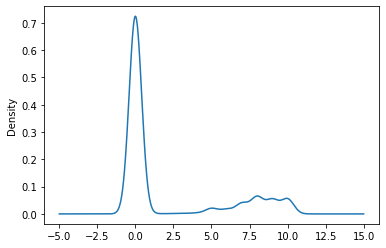

In [177]:
# Have a look at ratings distributions
df_filtered_ratings['rating'].plot(kind='density')

New size for filtered dataset:  (12640, 3)


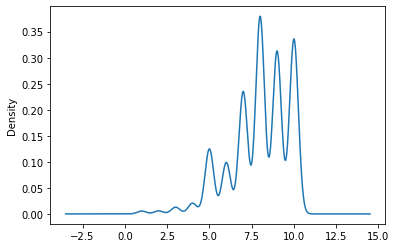

In [178]:
# Removing 0 values because project states scale is 1 - 10

df_filtered_ratings = df_filtered_ratings[df_filtered_ratings['rating'] > 0]
df_filtered_ratings['rating'].plot(kind='density')
print("New size for filtered dataset: ", df_filtered_ratings.shape)

In [185]:
# Create new clean df and modify user IDs to unique integers starting from 1
new_user_num = df_filtered_ratings.filter(like='user').stack().rank(method='dense').astype(int).unstack()
df_data = df_filtered_ratings.copy(deep=True)
df_data['user'] = new_user_num
df_data.head()

,user,isbn,rating
1456,833,002542730X,10.0
1474,833,0061009059,9.0
1522,833,0316776963,8.0
1543,833,0345413903,10.0
1578,833,0385424736,9.0


In [220]:
# Create the matrix for our nearest neighbor implementation
df_data_pivot = df_data.pivot(index='isbn', columns='user', values='rating').fillna(0)
data_matrix = csr_matrix(df_data_pivot.values)
df_data_pivot

user,1,2,3,4,5,6,7,8,9,10,...,826,827,828,829,830,831,832,833,834,835
isbn,,,,,,,,,,,,,,,,,,,,,
002542730X,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0
0060008032,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0060096195,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
006016848X,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0060173289,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1573227331,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1573229326,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1573229571,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [285]:
# Build NN Model 
model = NearestNeighbors(n_neighbors = 6, algorithm='auto', metric='cosine')
model.fit(data_matrix)

NearestNeighbors(metric='cosine', n_neighbors=6)

In [298]:
# function to return recommended books - this will be tested
def get_recommends(book = ""):

  # check to verify book exists, return error if not
  mybook = df_books.loc[df_books['title'] == book]
  if mybook.shape[0] == 0:
    return "Book Not Found"

  # Get book ID, build the search matrix array, and perform search
  bookid = mybook['isbn'].values[0]
  search_value = np.array(df_data_pivot.loc[bookid]).reshape(1, -1)
  distances, indices = model.kneighbors(search_value)

  #build results array as per the project specifications
  recommended_books = [book, []]
  for i in reversed(range(1,6)):
    booktitle = df_books.loc[df_books['isbn'] == df_data_pivot.index[indices[0][i]]]['title'].values[0]
    recommended_books[1].append([ booktitle, distances[0][i]])

  return recommended_books

In [299]:
books = get_recommends("Where the Heart Is (Oprah's Book Club (Paperback))")
print(books)

def test_book_recommendation():
  test_pass = True
  recommends = get_recommends("Where the Heart Is (Oprah's Book Club (Paperback))")
  if recommends[0] != "Where the Heart Is (Oprah's Book Club (Paperback))":
    test_pass = False
  recommended_books = ["I'll Be Seeing You", 'The Weight of Water', 'The Surgeon', 'I Know This Much Is True']
  recommended_books_dist = [0.8, 0.77, 0.77, 0.77]
  for i in range(2): 
    if recommends[1][i][0] not in recommended_books:
      test_pass = False
    if abs(recommends[1][i][1] - recommended_books_dist[i]) >= 0.05:
      test_pass = False
  if test_pass:
    print("You passed the challenge! 🎉🎉🎉🎉🎉")
  else:
    print("You haven't passed yet. Keep trying!")

test_book_recommendation()

["Where the Heart Is (Oprah's Book Club (Paperback))", [["I'll Be Seeing You", 0.8016211], ['The Weight of Water', 0.77085835], ['The Surgeon', 0.7699411], ['I Know This Much Is True', 0.7677075], ['The Lovely Bones: A Novel', 0.7234864]]]
You passed the challenge! 🎉🎉🎉🎉🎉
